In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch import optim

In [20]:
X = pd.read_csv('data/X.csv')
y = pd.read_csv('data/y.csv')

In [21]:
label_encoder = LabelEncoder()
y['sphus'] = label_encoder.fit_transform(y['sphus'])
print(y)

       sphus
0          1
1          0
2          0
3          0
4          0
...      ...
76817      0
76818      0
76819      0
76820      0
76821      0

[76822 rows x 1 columns]


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_ratio, random_state=123)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio / (test_ratio + validation_ratio), random_state=10117)
n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]
n = n_train + n_val + n_test
print((n_train / n), (n_val / n), (n_test / n)) 
if X_train.isna().any().any() or y_train.isna().any().any():
    print("NaNs in train data")
else:
    print("No NaNs in train data")
if (X_train == np.inf).any().any() or (y_train == np.inf).any().any():
    print("Infinities in train data")
else:
    print("No Infinities in train data")


0.6999947931582099 0.14999609486865742 0.15000911197313269
No NaNs in train data
No Infinities in train data


Imputing and Scaling

In [23]:
X_train_imputed = X_train.copy()
X_test_imputed = X_test.copy()
X_val_imputed = X_val.copy()

non_numeric_columns_train = X_train_imputed.select_dtypes(include=['object', 'bool']).columns
non_numeric_columns_test = X_test_imputed.select_dtypes(include=['object', 'bool']).columns
non_numeric_columns_val = X_val_imputed.select_dtypes(include=['object', 'bool']).columns

X_train_imputed[non_numeric_columns_train] = X_train_imputed[non_numeric_columns_train].fillna("missing")
X_test_imputed[non_numeric_columns_test] = X_test_imputed[non_numeric_columns_test].fillna("missing")
X_val_imputed[non_numeric_columns_val] = X_val_imputed[non_numeric_columns_val].fillna("missing")

numeric_columns_train = X_train_imputed.select_dtypes(include=[np.number]).columns
numeric_columns_test = X_test_imputed.select_dtypes(include=[np.number]).columns
numeric_columns_val = X_val_imputed.select_dtypes(include=[np.number]).columns
numeric_imputer = SimpleImputer(strategy='mean')

X_train_imputed[numeric_columns_train] = numeric_imputer.fit_transform(X_train_imputed[numeric_columns_train])
X_test_imputed[numeric_columns_test] = numeric_imputer.transform(X_test_imputed[numeric_columns_test])
X_val_imputed[numeric_columns_val] = numeric_imputer.transform(X_val_imputed[numeric_columns_val])
scaler = StandardScaler()

X_train_imputed_scaled = X_train_imputed.copy()
X_train_imputed_scaled[numeric_columns_train] = scaler.fit_transform(X_train_imputed[numeric_columns_train])

X_test_inputed_scaled = X_test_imputed.copy()
X_test_inputed_scaled[numeric_columns_test] = scaler.transform(X_test_imputed[numeric_columns_test])
X_val_imputed_scaled = X_val_imputed.copy()
X_val_imputed_scaled[numeric_columns_test] = scaler.transform(X_val_imputed[numeric_columns_test])



Convert to tensors

In [24]:
X_train_torch = torch.tensor(X_train_imputed_scaled.to_numpy().astype(np.float32))
X_val_torch = torch.tensor(X_val_imputed_scaled.to_numpy().astype(np.float32))
X_test_torch = torch.tensor(X_test_inputed_scaled.to_numpy().astype(np.float32))

y_train_torch = torch.tensor(y_train.to_numpy().astype(np.float32)).unsqueeze(1)
y_val_torch = torch.tensor(y_val.to_numpy().astype(np.float32)).unsqueeze(1)
y_test_torch = torch.tensor(y_test.to_numpy().astype(np.float32)).unsqueeze(1)


In [25]:
train_dataset = TensorDataset(X_train_torch, y_train_torch.long().view(-1)) 
val_dataset = TensorDataset(X_val_torch, y_val_torch.long().view(-1))
test_dataset = TensorDataset(X_test_torch, y_test_torch.long().view(-1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

try:
    num_classes = len(torch.unique(y_train_torch))
    assert torch.all((y_train_torch >= 0) & (y_train_torch < num_classes)), "Train targets out of range"
    assert torch.all((y_val_torch >= 0) & (y_val_torch < num_classes)), "Validation targets out of range"
    assert torch.all((y_test_torch >= 0) & (y_test_torch < num_classes)), "Test targets out of range"
    print("All OK")
except AssertionError as e:
    print(e)

All OK


Define Class Weights

In [26]:
class_counts = y_train['sphus'].value_counts().sort_index()
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights.to_numpy(), dtype=torch.float32)

Function for full workflow

In [27]:
def train_one_epoch(train_loader, model, loss_fn, optimizer):
    model.train()  
    total_loss = 0.0
    for batch in train_loader:
        inputs, targets = batch
        targets = targets.long().view(-1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    average_loss = total_loss / len(train_loader)
    return average_loss

def evaluate_model(data_loader, model, loss_fn):
    model.eval()  
    total_loss = 0.0
    with torch.no_grad():
        for batch in data_loader:
            inputs, targets = batch
            targets = targets.long().view(-1)
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
    average_loss = total_loss / len(data_loader)
    return average_loss

def train_and_validate(train_loader, val_loader, model, epochs, optimizer, loss_fn):
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        train_loss = train_one_epoch(train_loader, model, loss_fn, optimizer)
        train_losses.append(train_loss)
        val_loss = evaluate_model(val_loader, model, loss_fn)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
    model.load_state_dict(best_model_state)
    return model, train_losses, val_losses

def get_predictions(model, data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    return np.array(predictions)

def generate_classification_report(model, test_loader):
    predictions = get_predictions(model, test_loader)
    true_labels = []
    for _, targets in test_loader:
        true_labels.extend(targets.cpu().numpy())
    report = classification_report(true_labels, predictions, target_names=[str(cls) for cls in label_encoder.classes_], zero_division=0)
    print(f"\n Classification Report for {model.name}:")
    print(report)
    return report


Final workflow function

In [28]:
def run_workflow(models, train_loader, val_loader, test_loader, epochs=20):
    best_val_loss = float('inf')
    best_model = None
    results = []
    for model in models:
        print(f"\n Training model: {model.name}")
        loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        trained_model, train_losses, val_losses = train_and_validate(train_loader, val_loader, model, epochs, optimizer, loss_fn)
        test_loss = evaluate_model(test_loader, trained_model, loss_fn)
        classification_report_str = generate_classification_report(trained_model, test_loader)
        results.append({
            'model_name': model.__class__.__name__,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'test_loss': test_loss,
            'classification_report': classification_report_str
        })
        if min(val_losses) < best_val_loss:
            best_val_loss = min(val_losses)
            best_model = trained_model
        print(f"Completed training for model: {model.name}")
    return best_model, results


Define Models

In [29]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.hidden_size = hidden_size  
        self.hidden = nn.Linear(input_features, hidden_size)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_size, output_features)
    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.output(x)
        return F.softmax(x, dim=1)

class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features):
        super(DeepNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.output = nn.Linear(128, output_features)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.relu(self.bn1(self.layer1(x)))
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.relu(self.bn3(self.layer3(x)))
        x = self.output(x)
        return x

class DropoutNeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features):
        super(DropoutNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features, 500)
        self.layer2 = nn.Linear(500, 100)
        self.dropout = nn.Dropout(0.5)
        self.output = nn.Linear(100, output_features)
        self.leaky_relu = nn.LeakyReLU(0.01)
    def forward(self, x):
        x = self.leaky_relu(self.layer1(x))
        x = self.dropout(x)
        x = self.leaky_relu(self.layer2(x))
        x = self.output(x)
        return x

class CombinedNeuralNetwork(nn.Module):
    def __init__(self, input_features, output_features):
        super(CombinedNeuralNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(0.25)
        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(0.25)
        self.layer3 = nn.Linear(256, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.output = nn.Linear(128, output_features)
        self.leaky_relu = nn.LeakyReLU(0.01)
    def forward(self, x):
        x = self.dropout1(self.leaky_relu(self.bn1(self.layer1(x))))
        x = self.dropout2(self.leaky_relu(self.bn2(self.layer2(x))))
        x = self.leaky_relu(self.bn3(self.layer3(x)))
        x = self.output(x)
        return x

class MixedActivationNetwork(nn.Module):
    def __init__(self, input_features, output_features):
        super(MixedActivationNetwork, self).__init__()
        self.layer1 = nn.Linear(input_features, 128)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(128, 128)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.layer3 = nn.Linear(128, 64)
        self.elu = nn.ELU()
        self.output_layer = nn.Linear(64, output_features)
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.leaky_relu(self.layer2(x))
        x = self.elu(self.layer3(x))
        x = self.output_layer(x)
        return x

class ResidualBlock(nn.Module):
    def __init__(self, input_features, output_features):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(input_features, output_features)
        self.bn1 = nn.BatchNorm1d(output_features)
        self.relu = nn.ReLU(inplace=True)
        self.linear2 = nn.Linear(output_features, output_features)
        self.bn2 = nn.BatchNorm1d(output_features)
    def forward(self, x):
        identity = x
        out = self.linear1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out += identity  
        out = self.relu(out)
        return out

class ResNetRegression(nn.Module):
    def __init__(self, input_features, output_features, block, num_blocks):
        super(ResNetRegression, self).__init__()
        self.num_blocks = num_blocks
        self.input_features = input_features
        self.current_features = 64
        self.init_block = nn.Sequential(
            nn.Linear(input_features, self.current_features),
            nn.BatchNorm1d(self.current_features),
            nn.ReLU(inplace=True)
        )
        self.blocks = self._make_layer(block, 64, num_blocks)
        self.final_layer = nn.Linear(64, output_features)
    def _make_layer(self, block, output_features, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(self.current_features, output_features))
        return nn.Sequential(*layers)
    def forward(self, x):
        x = self.init_block(x)
        x = self.blocks(x)
        x = self.final_layer(x)
        return x

class GatingLayer(nn.Module):
    def __init__(self, input_features, output_features):
        super(GatingLayer, self).__init__()
        self.layer = nn.Linear(input_features, output_features)
        self.gate = nn.Sequential(
            nn.Linear(input_features, output_features),
            nn.Sigmoid()
        )
    def forward(self, x):
        x_transformed = self.layer(x)
        gate = self.gate(x)
        return x_transformed * gate

class DynamicRoutingNetwork(nn.Module):
    def __init__(self, input_features, output_features):
        super(DynamicRoutingNetwork, self).__init__()
        self.layer1 = GatingLayer(input_features, 128)
        self.layer2 = GatingLayer(128, 64)
        self.layer3 = GatingLayer(64, 64)
        self.output_layer = nn.Linear(64, output_features)
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.output_layer(x)
        return x

Initialize models

In [30]:
def model_name(models):
    model_names = []
    for model in models:
        try:
            name = f"{model.__class__.__name__} with {model.hidden_size} hidden nodes"
        except AttributeError:
            name = f"{model.__class__.__name__}"
        model.name = name
        model_names.append(name)
    return model_names

input_features = X_train_torch.shape[1]
output_features = num_classes  
base_nn_10 = NeuralNetwork(input_features=input_features, output_features=output_features, hidden_size=10)
base_nn_100 = NeuralNetwork(input_features=input_features, output_features=output_features, hidden_size=100)
deep_model = DeepNeuralNetwork(input_features=input_features, output_features=output_features)
dropout_model = DropoutNeuralNetwork(input_features=input_features, output_features=output_features)
combo_model = CombinedNeuralNetwork(input_features=input_features, output_features=output_features)
mixed_model = MixedActivationNetwork(input_features=input_features, output_features=output_features)
ResNet_model = ResNetRegression(input_features=input_features, output_features=output_features, block=ResidualBlock, num_blocks=3)
routing_model = DynamicRoutingNetwork(input_features=input_features, output_features=output_features)

models = [
    base_nn_10,
    base_nn_100,
    deep_model,
    dropout_model,
    combo_model,
    mixed_model,
    ResNet_model,
    routing_model
]

model_name(models)


['NeuralNetwork with 10 hidden nodes',
 'NeuralNetwork with 100 hidden nodes',
 'DeepNeuralNetwork',
 'DropoutNeuralNetwork',
 'CombinedNeuralNetwork',
 'MixedActivationNetwork',
 'ResNetRegression',
 'DynamicRoutingNetwork']

Run workflow

In [31]:
best_model, results = run_workflow(models, train_loader, val_loader, test_loader, epochs=20)
for result in results:
    print(f"Model: {result['model_name']}")
    print(f"Test Loss: {result['test_loss']:.4f}")
    print(f"Classification Report:\n{result['classification_report']}")


 Training model: NeuralNetwork with 10 hidden nodes

 Classification Report for NeuralNetwork with 10 hidden nodes:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     10064
           1       0.43      0.82      0.57      1460

    accuracy                           0.84     11524
   macro avg       0.70      0.83      0.73     11524
weighted avg       0.90      0.84      0.86     11524

Completed training for model: NeuralNetwork with 10 hidden nodes

 Training model: NeuralNetwork with 100 hidden nodes

 Classification Report for NeuralNetwork with 100 hidden nodes:
              precision    recall  f1-score   support

           0       0.97      0.84      0.90     10064
           1       0.42      0.81      0.55      1460

    accuracy                           0.83     11524
   macro avg       0.69      0.82      0.73     11524
weighted avg       0.90      0.83      0.85     11524

Completed training for model: NeuralNetwork w

Visualize training vs validation loss

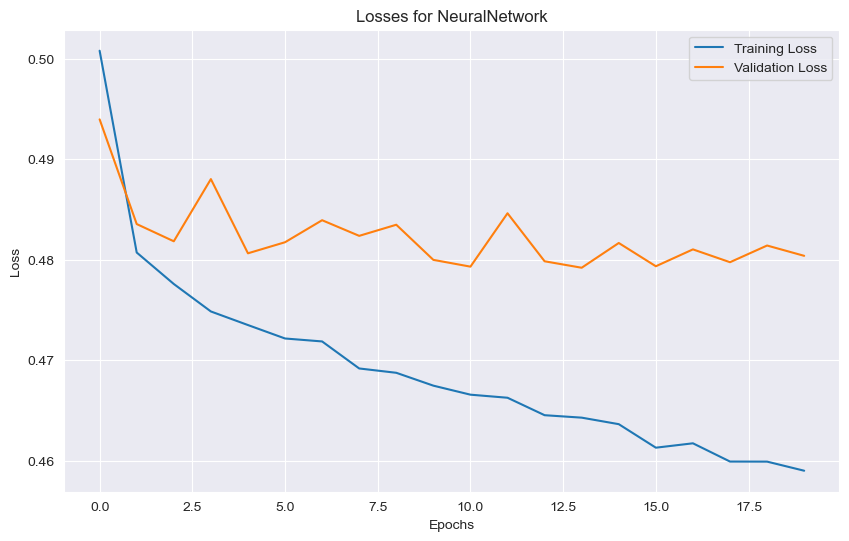

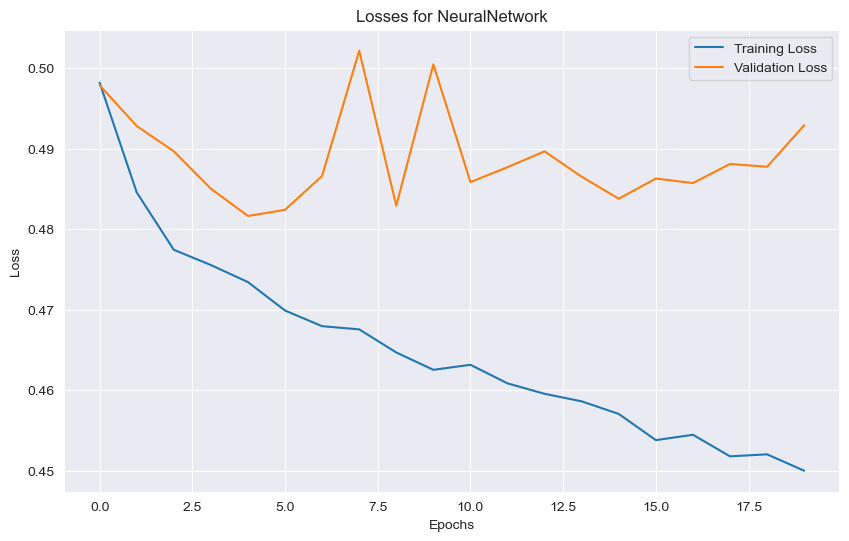

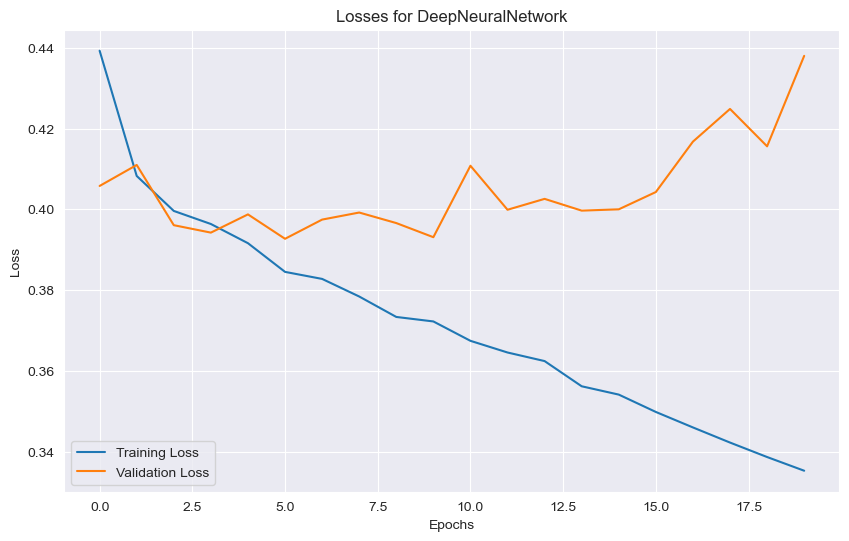

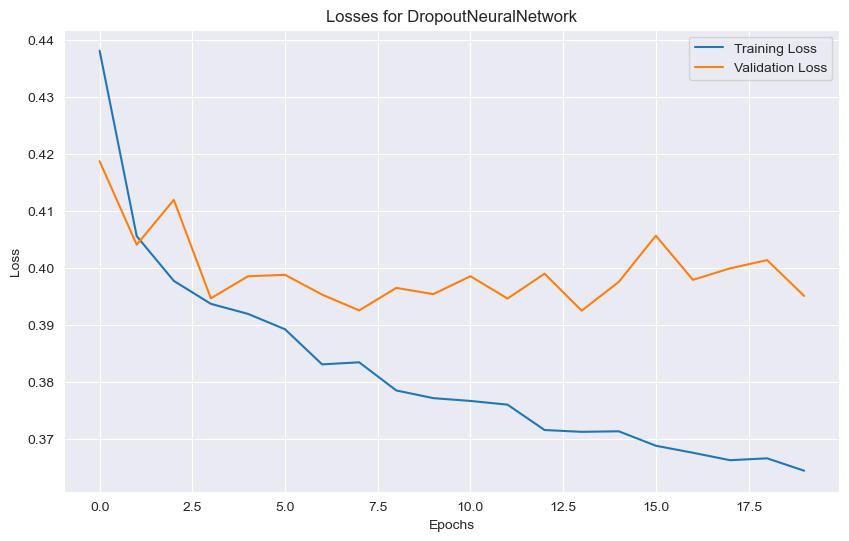

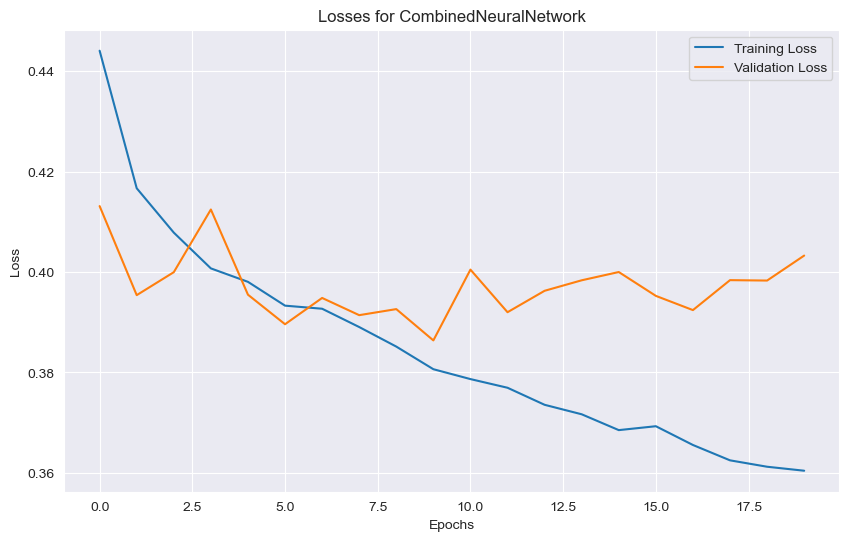

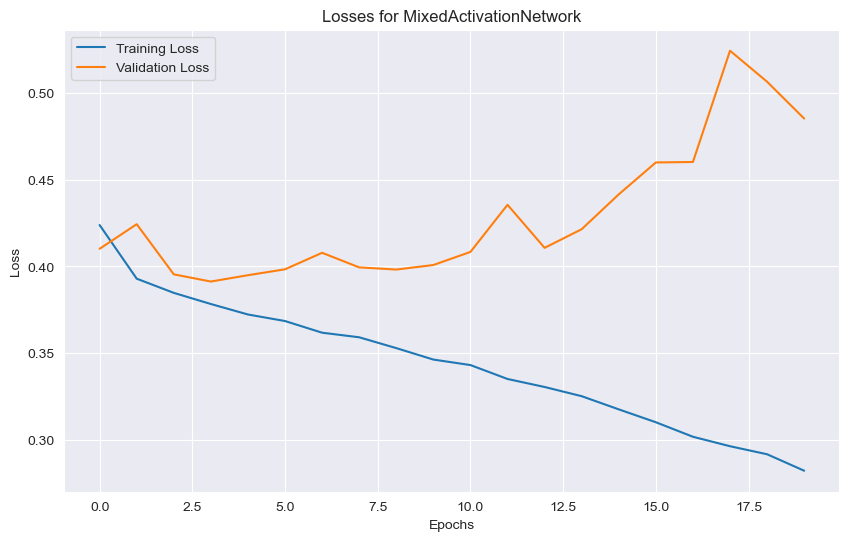

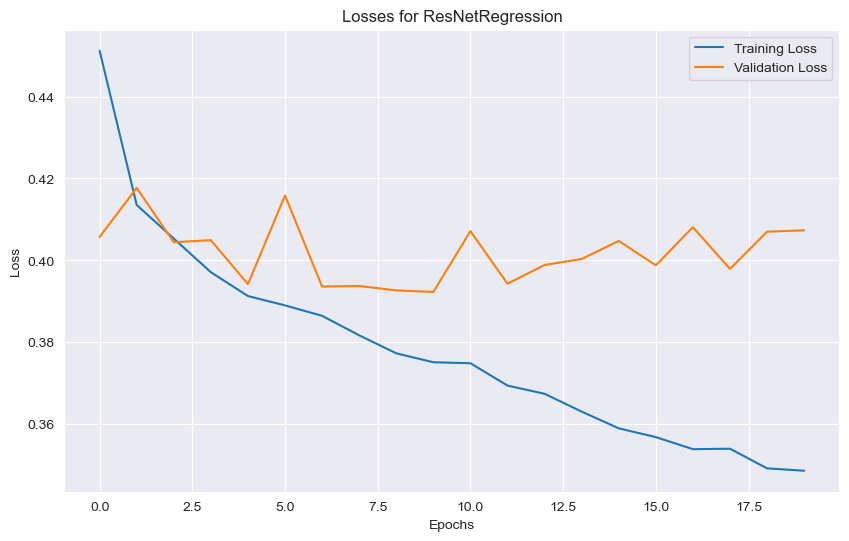

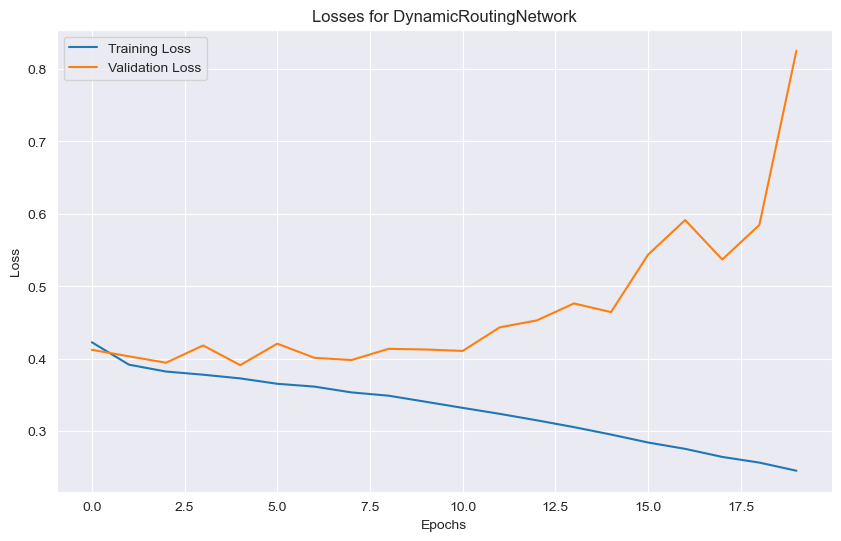

The best model is: CombinedNeuralNetwork


In [33]:
def plot_losses(results):
    for result in results:
        plt.figure(figsize=(10, 6))
        plt.plot(result['train_losses'], label='Training Loss')
        plt.plot(result['val_losses'], label='Validation Loss')
        plt.title(f"Losses for {result['model_name']}")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

def choose_best_model(results):
    best_model_name = None
    best_val_loss = float('inf')
    for result in results:
        if min(result['val_losses']) < best_val_loss:
            best_val_loss = min(result['val_losses'])
            best_val_loss = min(result['val_losses'])
            best_model_name = result['model_name']
    return best_model_name

# Visualization of validation errors over epochs
plot_losses(results)

# Choose and print the best model
best_model_name = choose_best_model(results)
print(f"The best model is: {best_model_name}")